In [1]:
from collections import defaultdict
import numpy as np
import scipy
import scipy.sparse as sps
import math
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_svmlight_file
import random
%matplotlib inline

# Support Vector Machines
## Classification Using SVM
Load dataset. We will use w1a dataset from LibSVM datasets https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/

The original optimization problem for the Support Vector Machine (SVM) is given by
\begin{equation}\label{eq:primal}
  \min_{w \in R^d} \  \sum_{i=1}^n \ell(y_i A_i^\top w) + \frac\lambda2 \|w\|^2
\end{equation}
where $\ell : R\rightarrow R$, $\ell(z) := \max\{0,1-z\}$ is the hinge loss function.
Here for any $i$, $1\le i\le n$, the vector $A_i\in R^d$ is the $i$-th data example, and $y_i\in\{\pm1\}$ is the corresponding label.
  
The dual optimization problem for the SVM is given by 
\begin{equation}\label{eq:dual}
 \max_{\boldsymbol{\alpha} \in R^n } \  \alpha^\top\boldsymbol{1} - \tfrac1{2\lambda} \alpha^\top Y A^\top AY\alpha
 \text{    such that    $0\le \alpha_i \le 1  \ \forall i$}
\end{equation}
where $Y := \mathop{diag}(y)$, and $A\in R^{d\times n}$ again collects all $n$ data examples as its columns. 



In [2]:
DATA_TRAIN_PATH = 'data/w1a'

A, y = load_svmlight_file(DATA_TRAIN_PATH)
A = A.toarray()
print(y.shape, A.shape)

(2477,) (2477, 300)


## Prepare cost and prediction functions

In [3]:
def hinge_loss(y, A, w):
    return np.max(1 - y * (A @ w), 0)

In [4]:
def calculate_primal_objective(y, A, w, lambda_):
    """compute the full cost (the primal objective), that is loss plus regularizer.
    A: the full dataset matrix, shape = (num_examples, num_features)
    y: the corresponding +1 or -1 labels, shape = (num_examples)
    w: shape = (num_features)
    """
    v = hinge_loss(y, A, w)
    return np.sum(v) + lambda_ / 2 * np.sum(w ** 2)

In [5]:
def accuracy(y1, y2):
    return np.mean(y1 == y2)

def prediction(A, w):
    return (A @ w > 0) * 2 - 1

def calculate_accuracy(y, A, w):
    """compute the training accuracy on the training set (can be called for test set as well).
    A: the full dataset matrix, shape = (num_examples, num_features)
    y: the corresponding +1 or -1 labels, shape = (num_examples)
    w: shape = (num_features)
    """
    predicted_y = prediction(A, w)
    return accuracy(predicted_y, y)

## Coordinate Descent (Ascent) for SVM

Compute the closed-form update for the i-th variable alpha, in the dual optimization problem, given alpha and the current corresponding w

In [6]:
def calculate_coordinate_update(y, A, lambda_, alpha, w, i):
    """compute a coordinate update (closed form) for coordinate i.
    A: the dataset matrix, shape = (num_examples, num_features)
    y: the corresponding +1 or -1 labels, shape = (num_examples)
    w: shape = (num_examples)
    i: the coordinate to be updated
    """        
    # calculate the update of coordinate at index=i.
    a_i, y_i = A[i], y[i]
    old_alpha_i = np.copy(alpha[i])
    
    g = (y_i * a_i.dot(w) - 1)

    if old_alpha_i == 0:
        g = min(g, 0)
    elif old_alpha_i == 1.0:
        g = max(g, 0)
    else:
        g = g
    if g != 0:
        alpha[i] = min(
            max(old_alpha_i - lambda_ * g / (a_i.T.dot(a_i)), 0.0),
            1.0)
    
        # compute the corresponding update on the primal vector w
        w += 1.0 / lambda_ * (alpha[i] - old_alpha_i) * y_i * a_i
    return w, alpha

In [7]:
def calculate_dual_objective(y, A, w, alpha, lambda_):
    """calculate the objective for the dual problem."""
    return np.sum(alpha)  - lambda_ / 2.0 * np.sum(w ** 2) # w = 1/lambda * A * Y * alpha

In [8]:
def coordinate_descent_for_svm_demo(y, A, trace=False):
    max_iter = 1000000
    lambda_ = 0.01
    history = defaultdict(list) if trace else None
    
    num_examples, num_features = A.shape
    w = np.zeros(num_features)
    alpha = np.zeros(num_examples)
    
    for it in range(max_iter):
        # i = sample one data point uniformly at random from the columns of A
        i = random.randint(0,num_examples-1)
        
        w, alpha = calculate_coordinate_update(y, A, lambda_, alpha, w, i)
            
        if it % 100000 == 0:
            # primal objective
            primal_value = calculate_primal_objective(y, A, w, lambda_)
            # dual objective
            dual_value = calculate_dual_objective(y, A, w, alpha, lambda_)
            # primal dual gap
            duality_gap = primal_value - dual_value
            
            print('iteration=%i, primal:%.5f, dual:%.5f, gap:%.5f'%(
                    it, primal_value, dual_value, duality_gap))
        if it % 1000 == 0:
            primal_value = calculate_primal_objective(y, A, w, lambda_)
            if trace:
                history["objective_function"] += [primal_value]
                history['iter'].append(it)

            
    print("training accuracy = {l}".format(l=calculate_accuracy(y, A, w)))
    return history

history_cd = coordinate_descent_for_svm_demo(y, A, trace=True)

iteration=0, primal:2219.70050, dual:0.00050, gap:2219.70000


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


iteration=100000, primal:272.71120, dual:215.44598, gap:57.26522
iteration=200000, primal:274.68409, dual:221.36225, gap:53.32185
iteration=300000, primal:242.59440, dual:223.78100, gap:18.81340
iteration=400000, primal:242.46060, dual:224.71571, gap:17.74489
iteration=500000, primal:237.49218, dual:225.40024, gap:12.09194
iteration=600000, primal:238.33054, dual:225.88257, gap:12.44798
iteration=700000, primal:236.36468, dual:226.37452, gap:9.99016
iteration=800000, primal:234.80331, dual:226.72507, gap:8.07824
iteration=900000, primal:235.19958, dual:227.04223, gap:8.15735
training accuracy = 0.994751715785224


# Stochastic gradient descent for SVM

Let's now compare it with SGD on original problem for the SVM

In [9]:
def compute_stoch_gradient_svm(A_batch, b_batch, reg_coef, w_t, num_data_points):
    z = A_batch.dot(w_t) * b_batch
    if z >= 1:
        gradient = reg_coef * w_t
    else:
        gradient = reg_coef * w_t - num_data_points * b_batch * A_batch
    return gradient.reshape(-1)

In [10]:
def stochastic_gradient_descent_svm_demo(A, b, gamma, batch_size=1, trace=False):
    history = defaultdict(list) if trace else None
    num_data_points, num_features = np.shape(A)
    max_iter = 1000000
    reg_coef = 0.01
    
    
    w_t = np.zeros(num_features)
    
    for current_iter in range(max_iter):
        i = random.randint(0,num_data_points - 1)
        b_batch, A_batch = b[i], A[i]
        gradient = compute_stoch_gradient_svm(A_batch, b_batch, reg_coef, w_t, num_data_points)
        w_t = w_t - gamma * gradient
        if current_iter % 100000 == 0:
            primal_value = calculate_primal_objective(y, A, w_t, reg_coef)
            print('iteration=%i, primal:%.5f'%(
                    current_iter, primal_value))
        if current_iter % 1000 == 0:
            primal_value = calculate_primal_objective(y, A, w_t, reg_coef)
            if trace:
                history['objective_function'].append(primal_value)
                history['iter'].append(current_iter)
    print("training accuracy = {l}".format(l=calculate_accuracy(y, A, w_t)))
    return history


Try different stepsized and find the best one

In [11]:
history_sgd_3 = stochastic_gradient_descent_svm_demo(A, y, 1e-3, batch_size=1, trace=True)
history_sgd_4 = stochastic_gradient_descent_svm_demo(A, y, 1e-4, batch_size=1, trace=True)
history_sgd_5 = stochastic_gradient_descent_svm_demo(A, y, 1e-5, batch_size=1, trace=True)
history_sgd_6 = stochastic_gradient_descent_svm_demo(A, y, 1e-6, batch_size=1, trace=True)

iteration=0, primal:1709.66271
iteration=100000, primal:350.19098
iteration=200000, primal:350.43131
iteration=300000, primal:378.42061
iteration=400000, primal:378.91468
iteration=500000, primal:366.99914
iteration=600000, primal:388.49145
iteration=700000, primal:342.32530
iteration=800000, primal:371.07730
iteration=900000, primal:331.81144
training accuracy = 0.9923294307630198
iteration=0, primal:1639.40579
iteration=100000, primal:259.88966
iteration=200000, primal:240.97706
iteration=300000, primal:240.20156
iteration=400000, primal:238.33349
iteration=500000, primal:238.82725
iteration=600000, primal:240.25342
iteration=700000, primal:236.10446
iteration=800000, primal:240.02449
iteration=900000, primal:237.11845
training accuracy = 0.9943480016148567
iteration=0, primal:2231.67803
iteration=100000, primal:274.50292
iteration=200000, primal:261.98562
iteration=300000, primal:253.34392
iteration=400000, primal:249.16985
iteration=500000, primal:245.72435
iteration=600000, primal

Lets plot

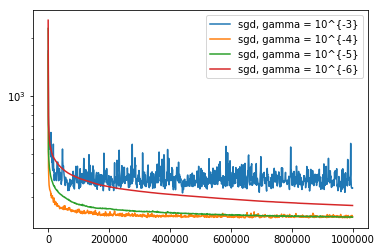

In [12]:
plt.semilogy(history_sgd_3["iter"], history_sgd_3["objective_function"], label="sgd, gamma = 10^{-3}")
plt.semilogy(history_sgd_4["iter"], history_sgd_4["objective_function"], label="sgd, gamma = 10^{-4}")
plt.semilogy(history_sgd_5["iter"], history_sgd_5["objective_function"], label="sgd, gamma = 10^{-5}")
plt.semilogy(history_sgd_6["iter"], history_sgd_6["objective_function"], label="sgd, gamma = 10^{-6}")
plt.legend()

We see that the best stepsize is $10^{-4}$.

## Compare SGD with Coordinate Descent

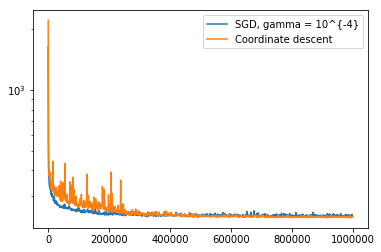

In [13]:
plt.semilogy(history_sgd_4["iter"], history_sgd_4["objective_function"], label="SGD, gamma = 10^{-4}")
plt.semilogy(history_cd["iter"], history_cd["objective_function"], label="Coordinate descent")
plt.legend()

Time-wise SGD and coordinate descent have the same per iteration time complexities. On the graph above SGD with the best stepsize converges with approximately the same speed than coordinate descent iteration-wise, while coordinate descent doesn't require any parameter tuning! 